# 감성 분석 모델 학습 및 추론

### 1. 데이터 로드

In [34]:
# 1. 사전 학습된 모델 또는 적절한 데이터셋을 찾는다.
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import numpy

### 2. 데이터 전처리

In [35]:
import string

data_df = pd.read_csv('finance_data.csv')
data_df.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [36]:
data_df.isna().sum()

labels          0
sentence        0
kor_sentence    0
dtype: int64

In [37]:
data_df = data_df.drop('sentence', axis=1)

In [38]:
data_df

,labels,kor_sentence
0,neutral,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...
4841,negative,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [39]:
VOCAB_SIZE = 1000
SEQ_LEN = 150

data_df['labels'] = data_df['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])


X_data = data_df['kor_sentence']
y_data = data_df['labels']

C:\Users\Playdata\AppData\Local\Temp\ipykernel_4852\3960236911.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df['labels'] = data_df['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])


In [51]:
from konlpy.tag import Okt
okt = Okt()
data_df['tokenized'] = data_df['kor_sentence'].apply(okt.morphs)
data_df

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르면, ,, 그, 회사, 는, 회사, 가, 성장하고, 있는, 곳..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노, 폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하는, 회..."
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...","[국제, 전자, 산업, 회사, 인, 엘코텍, 은, 탈린, 공장, 에서, 수십, 명의..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되는, 수요, 증가, 를..."
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...","[2009-2012년, 회사, 의, 업데이트, 된, 전략, 에, 따르면, ,, Ba..."
...,...,...,...
4841,2,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...,"[런던, 마켓, 워치, --, 은행, 주의, 반등, 이, FTSE, 100, 지수,..."
4842,0,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...,"[린, 쿠스, 키, 아, 의, 맥주, 판매량, 은, 416만, 리터, 로, 6.5%..."
4843,2,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이...","[영업, 이익, 은, 2007년, 68.8, mn, 에서, 35.4, mn, 으로,..."
4844,2,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...,"[페이퍼, 부문, 순, 매출, 은, 2008년, 2분, 기, 241.1, mn, 에..."


In [52]:
X_data = data_df['tokenized']
y_data = data_df['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4846
레이블의 개수: 4846


### 3. 모델 정의 및 생성

In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

print(X_train_enc[:5])
print(X_test_enc[:5])

[[149, 164, 919, 438, 410, 78, 3426, 4979, 94, 9, 238, 29, 158, 364, 19, 78, 217, 26, 471, 2, 4980, 3, 195, 18, 96, 1], [81, 451, 678, 230, 648, 852, 201, 20, 2168, 4981, 2650, 6, 4982, 4983, 2169, 88, 3, 210, 9, 115, 133, 129, 4984, 8, 4985, 1571, 679, 25, 1832, 9, 29, 4986, 3427, 3, 59, 1572, 1833, 1265, 26, 225, 44, 85, 150, 9, 4987, 36, 196, 489, 31, 26, 1834, 118, 3, 28, 59, 89, 38, 10, 1], [202, 1573, 1835, 2, 339, 3, 979, 147, 7, 745, 707, 2170, 27, 745, 707, 3428, 8, 1836, 231, 708, 5, 3429, 2651, 2171, 27, 2652, 4988, 4989, 4990, 9, 175, 58, 218, 19, 920, 2, 2653, 151, 4, 1056, 1574, 22, 37, 439, 921, 340, 1], [619, 5, 124, 219, 38, 3, 1266, 12, 13, 121, 189, 1], [68, 38, 311, 27, 311, 490, 5, 58, 491, 2, 3430, 186, 14, 3, 105, 66, 2654, 186, 14, 166, 1]]
[[8, 766, 9, 175, 1770, 19, 6, 615, 331, 3, 3772, 1825, 2, 684, 9, 115, 297, 693, 203, 4794, 1825, 2, 812, 4, 889, 22, 37, 462, 74, 1], [50, 329, 44, 19, 6, 334, 2076, 9533, 16, 12, 21, 1], [181, 267, 1403, 535, 68, 2, 45, 39

In [55]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

10964


본문의 최대 길이 : 62
본문의 평균 길이 : 23.917698658410732


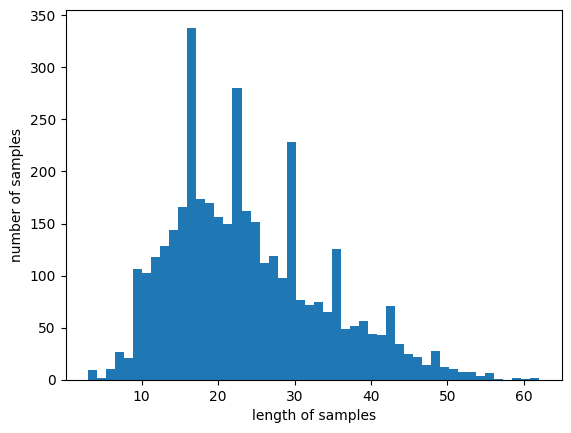

In [56]:
import matplotlib.pyplot as plt

print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 4. 모델 학습

In [57]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

max_len = 15

X_train_enc = pad_sequences(X_train_enc, maxlen=max_len)
X_test_enc = pad_sequences(X_test_enc, maxlen=max_len)


In [58]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, LSTM

embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_enc, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15


91/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5799 - loss: 0.9531
Epoch 1: val_acc improved from None to 0.71263, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.6206 - loss: 0.8559 - val_acc: 0.7126 - val_loss: 0.6824
Epoch 2/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7452 - loss: 0.5845
Epoch 2: val_acc improved from 0.71263 to 0.74227, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7752 - loss: 0.5383 - val_acc: 0.7423 - val_loss: 0.5906
Epoch 3/15
95/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9090 - loss: 0.2510
Epoch 3: val_acc did not improve from 0.74227
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9061 - loss: 0.2543 - val_acc: 0.7358 - val_loss: 0.7302
Epoch 4/15
94/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9702 - loss: 0.0992
Epoch 4: val_acc did not improve from 0.74227
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9687 - loss: 0.0991 - val_acc: 0.7281 - val_loss: 0.8424
Epoch 5/15
88/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9895 - loss: 0.0519
Epoch 5: val_acc did not improve from 0.74227
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9868 - loss: 0.0492 - val_acc: 0.7423 - val_loss: 1.0325
Epoch 6/15
91/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9913 - loss: 0.0334
Epoch 6: val_acc did not improve from 0.74227
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9923 - loss: 0.0311 - val_acc: 0

In [60]:
import numpy as np
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_enc, y_train, epochs=15)

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9422 - loss: 0.1407
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.0746
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9840 - loss: 0.0395
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9923 - loss: 0.0239
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0180
Epoch 6/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0100
Epoch 7/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9959 - loss: 0.0131
Epoch 8/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9956 - loss: 0.0131
Epoch 9/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9969 - loss: 0.0086
Epoch 10/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0053
Epoch 11/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0045
Epoch 12/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

### 5. 추론

In [63]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_enc, y_test)[1]))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7392 - loss: 0.6460 

 테스트 정확도: 0.7392
